##Importing and Pre-Processing Data and Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
yld = glob.glob("/content/drive/MyDrive/Colab Notebooks/01_CHMNet_DS/YLD/*.*")
healthy = glob.glob("/content/drive/MyDrive/Colab Notebooks/01_CHMNet_DS/Healthy/*.*")
mites = glob.glob("/content/drive/MyDrive/Colab Notebooks/01_CHMNet_DS/Mites/*.*")
grassy_shoots = glob.glob("/content/drive/MyDrive/Colab Notebooks/01_CHMNet_DS/Grassy Shoots/*.*")
ring_spots = glob.glob("/content/drive/MyDrive/Colab Notebooks/01_CHMNet_DS/Ring Spot/*.*")

In [ ]:
data = []
labels = []

def append_data_label(images, number):
  for i in images:
    image = tf.keras.preprocessing.image.load_img(i, color_mode="rgb", target_size=(256,256))
    image = np.array(image)
    data.append(image)
    labels.append(number)

In [ ]:
append_data_label(healthy, 0)
append_data_label(yld, 1)
append_data_label(mites, 2)
append_data_label(grassy_shoots, 3)
append_data_label(ring_spots, 4)

In [ ]:
data = np.array(data)/255
labels = np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
label_names = ["Healthy", "YLD", "Mites", "Grassy Shoots", "Ring Spots"]

In [ ]:
X_train2[1].shape

(256, 256, 3)

##Xception model

In [ ]:
from tensorflow.keras.applications.xception import Xception

In [ ]:
cnn_model = Xception(weights="imagenet", include_top=False, pooling="max")
cnn_model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [ ]:
features_train = []
for img in X_train2:
  img = np.expand_dims(img, axis=0)
  feature = cnn_model.predict(img, verbose=0)
  features_train.append(feature)

In [ ]:
features_test = []
for img in X_test2:
  img = np.expand_dims(img, axis=0)
  feature = cnn_model.predict(img, verbose=0)
  features_test.append(feature)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

## Model building and saving

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape
import tensorflow as tf

In [ ]:
features = []

for img in data:
  img = np.expand_dims(img, axis=0)
  feature = cnn_model.predict(img, verbose=0)
  features.append(feature)

In [ ]:
features = np.array(features)

In [ ]:
model2 = Sequential()
model2.add(Input(shape=(1,2048), name="img_input_layer"))
model2.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
model2.add(Reshape((1, 256)))  # Reshape the output from the previous layer
model2.add(LSTM(256))
model2.add(tf.keras.layers.Dense(64, activation="relu"))
model2.add(tf.keras.layers.Dense(32, activation="relu"))
model2.add(tf.keras.layers.Dense(5, activation="softmax"))

In [ ]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1, 256)            524544    
                                                                 
 reshape_7 (Reshape)         (None, 1, 256)            0         
                                                                 
 lstm_9 (LSTM)               (None, 256)               525312    
                                                                 
 dense_31 (Dense)            (None, 64)                16448     
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1068549 (4.08 MB)
Trainable params: 106

In [ ]:
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics =["accuracy"])

In [ ]:
history = model2.fit(x=features, y=labels, epochs=15)

Epoch 1/15
16/16 [==============================] - 4s 28ms/step - loss: 1.3138 - accuracy: 0.4726
Epoch 2/15
16/16 [==============================] - 0s 27ms/step - loss: 0.6200 - accuracy: 0.7789
Epoch 3/15
16/16 [==============================] - 0s 25ms/step - loss: 0.2973 - accuracy: 0.9047
Epoch 4/15
16/16 [==============================] - 0s 25ms/step - loss: 0.1283 - accuracy: 0.9655
Epoch 5/15
16/16 [==============================] - 0s 28ms/step - loss: 0.0565 - accuracy: 0.9838
Epoch 6/15
16/16 [==============================] - 0s 22ms/step - loss: 0.0257 - accuracy: 0.9980
Epoch 7/15
16/16 [==============================] - 0s 18ms/step - loss: 0.0131 - accuracy: 1.0000
Epoch 8/15
16/16 [==============================] - 0s 18ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 9/15
16/16 [==============================] - 0s 18ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 10/15
16/16 [==============================] - 0s 17ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 11/

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'], label='training accuracy')
plt.plot(history2.history['val_accuracy'], label='validation accuracy')
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
# model2.save("/content/drive/MyDrive/Colab Notebooks/prediction_disease.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# model2.save("/content/drive/MyDrive/Colab Notebooks/prediction_disease_2.keras")

## Model Testing

In [ ]:
model =  tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/prediction_disease.h5")

'Ring Spots'

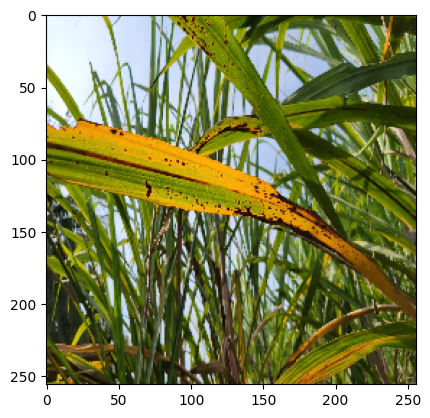

In [ ]:
x = 50;
import matplotlib.pyplot as plt
plt.imshow(X_test2[x], cmap=plt.cm.binary)
label_names[y_test2[x]]

In [ ]:
data_to_predict = np.expand_dims(features_test[x], axis=0)

prediction = model.predict(data_to_predict)

1/1 [==============================] - 0s 45ms/step


In [ ]:
prediction_name = label_names[np.argmax([prediction])]
prediction_name

'Ring Spots'

######Verification

In [ ]:
for x in range(70):
  data_to_predict = np.expand_dims(features_test[x], axis=0)
  prediction = model.predict(data_to_predict)
  prediction_name = label_names[np.argmax([prediction])]
  print(label_names[y_test2[x]], " -> ", prediction_name)

1/1 [==============================] - 0s 26ms/step
Ring Spots  ->  Ring Spots
1/1 [==============================] - 0s 24ms/step
Healthy  ->  Healthy
1/1 [==============================] - 0s 21ms/step
Grassy Shoots  ->  Grassy Shoots
1/1 [==============================] - 0s 25ms/step
YLD  ->  YLD
1/1 [==============================] - 0s 21ms/step
Grassy Shoots  ->  Grassy Shoots
1/1 [==============================] - 0s 34ms/step
Mites  ->  Mites
1/1 [==============================] - 0s 23ms/step
YLD  ->  YLD
1/1 [==============================] - 0s 25ms/step
Healthy  ->  Healthy
1/1 [==============================] - 0s 24ms/step
Grassy Shoots  ->  Grassy Shoots
1/1 [==============================] - 0s 25ms/step
Healthy  ->  Healthy
1/1 [==============================] - 0s 29ms/step
YLD  ->  YLD
1/1 [==============================] - 0s 25ms/step
YLD  ->  YLD
1/1 [==============================] - 0s 24ms/step
Mites  ->  Mites
1/1 [==============================] - 0s 25ms/st